# Lesson 1 - Image classification, AKA What's your pet

**Objectives**
- know best practices for training neural networks
- learn how to familiarize ourselves with data before training models
- understand why we normalize training data
- explain why we use a validation set
- define **transfer learning** and explain its advantages
- define an **epoch** in terms of training neural networks
- relate **fine tuning** to transfer learning

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Introduction

Why learn about neural networks?

### Common reasons given to **not** use neural networks
- black box
  + ok, maybe, but many people working on Interpretable ML
  + many ways to visualize what goes on in network, make it a "clear box"
    - https://github.com/microsoft/tensorwatch
    - https://github.com/DistrictDataLabs/yellowbrick
- need too much data
  + many available pre-trained networks
  + **transfer learning** allows for adapting these networks 
- you need a machine learning Ph.D. to use them
  + many high-level libraries
    - fast.ai <https://github.com/fastai/fastai>
    - keras <https://github.com/keras-team/keras>
- they're only for computer vision tasks
  + no, they are state of the art for: speech recognition, natural language processing, reinforcement learning, etc.
- you need specialized hardware, e.g., "deep learning rig" with GPUs
  + no, for many applications you can work in the cloud
    - e.g. CoLab notebooks we are using
    - Amazon Web Services
- "not really AI"
  + you don't care, unless you are actually a researcher studying Artificial Intelligence

## Image classification with neural networks

As we have just learned, neural networks are state of the art for many machine learning tasks. However it is fair to say that computer vision tasks like image classification are far-and-away their most common application. Since neural networks are so commonly used in this domain, we'll learn about them by walking through an example of using them to perform such as task.

### Example image classification task: Oxford-IIIT Pet Dataset

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. 

This is known as **fine-grained classification**, and is still a challenging computer vision problem (as of summer 2019). According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

### Looking at the data
**The first thing we do when we approach a problem is to take a look at the data.**  
We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it.
Taking a look at the data means:
- understanding how the data directories are structured
- what the labels are 
- and what some sample images look like.

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/home/ildefonso/.fastai/data/oxford-iiit-pet')

(We're using `Path`s from the Python standard libray to conveniently work with files, for more about this see:  
<https://treyhunner.com/2018/12/why-you-should-be-using-pathlib/>  
<https://treyhunner.com/2019/01/no-really-pathlib-is-great/>)

In [6]:
path.ls()

[PosixPath('/home/ildefonso/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/ildefonso/.fastai/data/oxford-iiit-pet/annotations')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

**Look at filenames to see what the format is.**

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/ildefonso/.fastai/data/oxford-iiit-pet/images/Russian_Blue_10.jpg'),
 PosixPath('/home/ildefonso/.fastai/data/oxford-iiit-pet/images/shiba_inu_199.jpg'),
 PosixPath('/home/ildefonso/.fastai/data/oxford-iiit-pet/images/pomeranian_100.jpg'),
 PosixPath('/home/ildefonso/.fastai/data/oxford-iiit-pet/images/saint_bernard_141.jpg'),
 PosixPath('/home/ildefonso/.fastai/data/oxford-iiit-pet/images/Birman_116.jpg')]

**Write a regular expression that lets us extract labels from the filenames.**

In [9]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

**then use the "from regular expression" factory function to create an `ImageDataBunch`** with all our images and the labels for them that we extract from the file name.

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, 
                                   ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Notice that:
  - we have to make all the images the **same size** (in this case, `size=224`)
    + GPUs need images all the same size to run the same operations on many images in parallel
  - we **normalize** the images (zero-center the mean and divide by the standard deviation for each channel of RGB images) (by calling `.normalize(imagenet_stats)`
    + we want it to be normalized **in the same way** as the data that was used previously (the ImageNet dataset) to train weights in the neural network we're going to adapt to our task
    + general machine learning issue: don't want results to depend on scale differences between features
      - e.g. "red channel is always brighter"
    + for a neural network, large values can do weird things to activation, loss function, etc.

**We look at a random sample of the dataset** using the `show_batch` method of our `ImageDataBunch`.

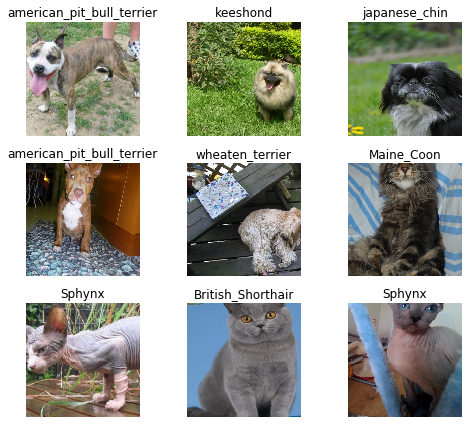

In [11]:
data.show_batch(rows=3, figsize=(7,6))

**We also look at the names of the classes.**

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training neural networks: transfer learning

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Calling `cnn_learner` downloaded some weights.

That's because we will take a resnet34 model, with weights pre-trained on the ImageNet dataset, and then use **transfer learning** to very quickly adapt the model so it can perform our fine-grained classification task.

### Validation sets
The `fastai` library by default creates a validation set from our `ImageDataBunch`. During training, we look at the error measured on this validation set (by setting `metrics=error_rate`), to know that we're not just memorizing the right answers for our training set. Neural networks are expressive but they can also very easily **overfit** the training data.  Using a validation set helps prevent overfitting.

### Neural network layers in the wild
We can see our model's layers by printing the `model` attribute of our `learner`

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

We will train for 4 **epochs** (cycles through all our data).

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.409939,0.357608,0.102165
2,0.539408,0.242496,0.073072
3,0.340212,0.221338,0.066306
4,0.261859,0.216619,0.071042


In [ ]:
learn.save('stage-1')

## Sanity checks on training

Let's see what results we have got. 
`fastai` provides us with a Python class, `ClassificationInterpretation`, that helps us interpret the behavior of our model. We pass it the model.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

True

### loss function

To get some insight into how our model was trained, we can look at statistics of the **loss function**. The loss function is what we optimize during training, typically by finding weights that minimize its values. We plot the top losses, where the loss takes on a large value because we are *confidently wrong*, i.e. we mis-classify an image, and we assign a high probability to ur estimate that the image belongs to this (wrong) class.

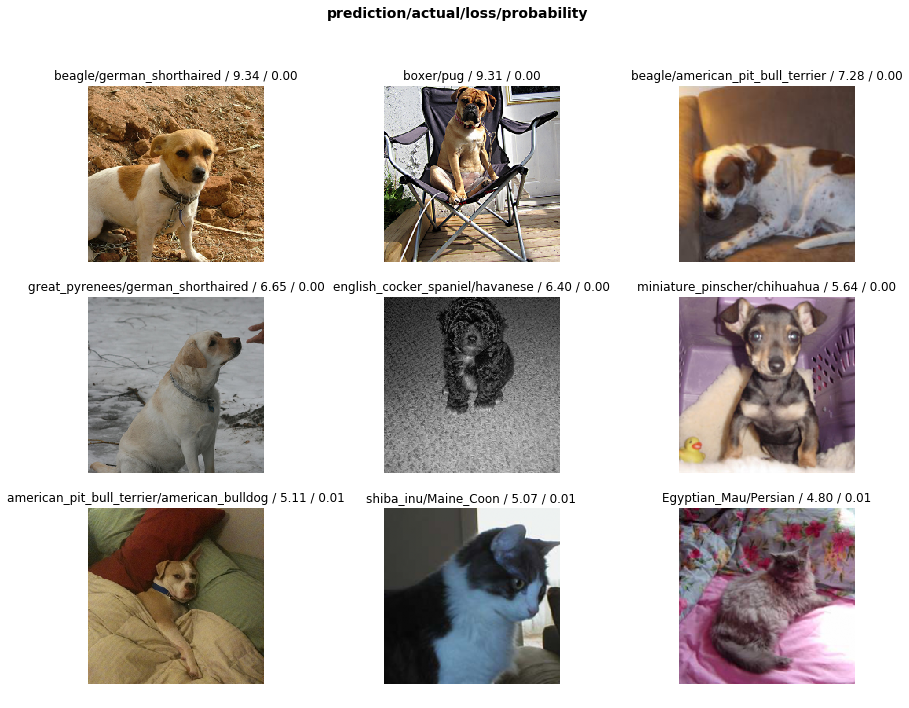

In [ ]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

We have plotted which were the categories that the model most confused with one another. This lets us see if  if what the model predicted was reasonable or not. **In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.**

### confusion matrix
Then we plot a **confusion matrix**. When we do this, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

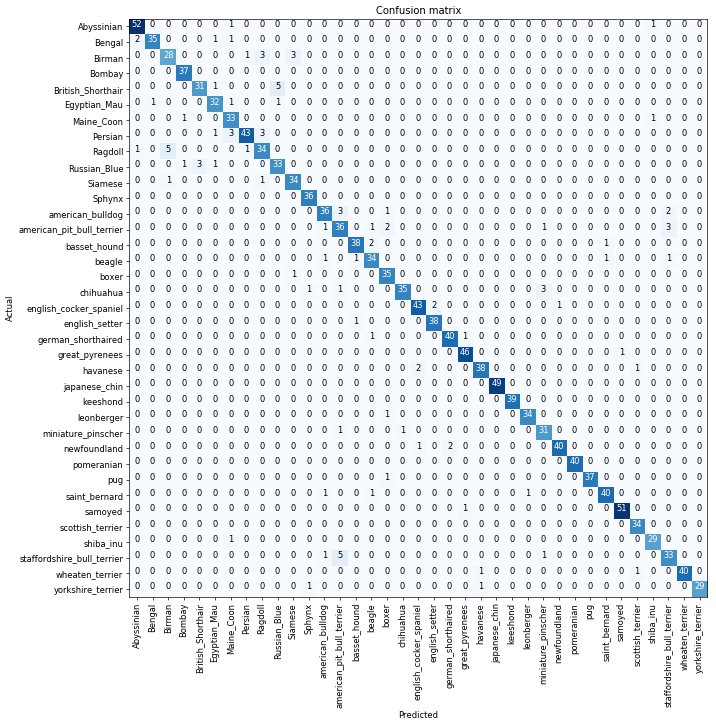

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('British_Shorthair', 'Russian_Blue', 5),
 ('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Birman', 'Ragdoll', 3),
 ('Birman', 'Siamese', 3),
 ('Persian', 'Maine_Coon', 3),
 ('Persian', 'Ragdoll', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('chihuahua', 'miniature_pinscher', 3)]

## Unfreezing, fine-tuning, and learning rates

By default, when we use `fastai` to do transfer learning, the library **freezes** the pre-trained weights in all layers except the last one. The last layer gets replaced with a *new* layer that performs the new task. In our example, this a layer that outputs probabilities of the image being one of 37 dog and cat breeds, instead of outputting probabilities for the 1000 classes in the ImageNet set.

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.558166,0.314579,0.101489


Our error rate got worse.

Why?

Because we used the same **learning rate** across all the different layers.

But different layers recognize different **features**.
![auto-seen-by-net](./images/autos-672x378.png)  
from <https://blogs.nvidia.com/blog/2018/09/05/whats-the-difference-between-a-cnn-and-an-rnn/>  

We don't want to change the features that the filters in the lower layers of our convolutional network recognize: we don't expect the statistics of real-world images to change dramatically. We'll probably do better if we change those filters more slowly, while we rapdily change the filters that combine lower-level features to create higher-level, **semantic** representations.

We can do this by varying the **learning rate** across layers.

Using learning rates that are lower than usual, in combination with pre-trained weights, is often called **fine tuning**.

`fastai` provides us with convenience functions to find pretty good learning rates for fine tuning.
First we load the model back that we saved previously.

In [ ]:
learn.load('stage-1');

Then we use the `lr_find` method of our `learner` to find good learning rates.

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


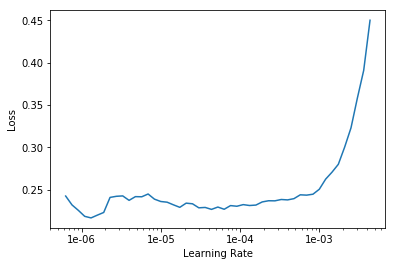

In [ ]:
learn.recorder.plot()

The plot tells us that between `1e-6` and `1e-4` is a good range; anything higher than that and the loss grows exponentially, meaning our optimization will be unstable.

So we `unfreeze` the weights as before, but this time we specify a range of learning rates.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.242544,0.208489,0.067659
2,0.206940,0.204482,0.062246


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a **deeper** network with **more parameters**. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


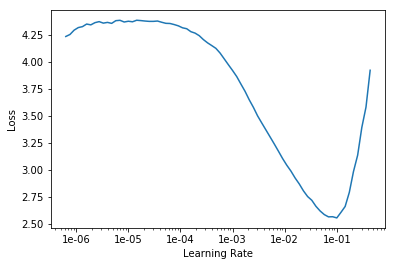

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Key Points
- always visualize data before training models
  + for image classification:
    - look at example images, before and after pre-processing
    - look at and understand labels 
- normalize data
  + so model doesn't make predictions based on magnitude of features
  + so that optimization is better behaved
- use a validation set to prevent over-fitting
- transfer learning enables us to rapidly adapt pre-trained models to new tasks, e.g. train for fewer epochs
  - an epoch is one pass through all the training data
- fine tuning is using smaller than normal learning rates, typically in the context of transfer learing
  + a typical workflow with `fastai` is to first train a new output layer, AKA "head" with a normal learning rate with weights in lower layers frozen, then unfreeze the weights and perform fine-tuning
- generally speaking, "deeper" models with more layers achieve higher accuracy
  + partly because of more parameters
  + but theoretical work suggests that deeper models can learn more complicated functions than a "wide" model with the same number of parameters